# Problem set 1, Asymmetric loss regression

First, Let's load the data and plot the training data out.

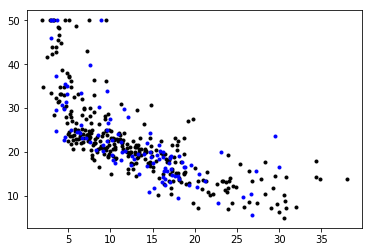

In [1]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt


# Load data
dataTrain=np.loadtxt('housing-train.txt')
dataVal=np.loadtxt('housing-val.txt')

X_train=(dataTrain[:,np.newaxis,0])
y_train=dataTrain[:,1]
X_val=dataVal[:,np.newaxis,0]
y_val=dataVal[:,1]

plt.plot(X_train, y_train, 'k.')
plt.plot(X_val, y_val, 'b.')


First, we will solve the linear regression (under the "normal" symmetric squared loss) using the closed form solution. Let's define a couple of functions we will need.

In [2]:
def symmLoss(X, w ,y):
    """
    Get the symmetric squared loss given data X, weight w and ground truth y

    Parameters
    ----------
    X : 2D array
        N x d+1 data matrix (row per example)
    w : 1D array
        d+1 length vector
    y : 1D array
        Observed function values

    Returns
    -------
    loss : a scalar
        The loss calculated by the symmetric loss formula
    """
    return np.mean((np.dot(X, w) - y)**2)

Note that the loss we have defined is the normalized squared loss

In [3]:
def lsqClosedForm(X, y):
    """
    Use closed form solution for least squares minimization

    Parameters
    ----------
    X : 2D array
        N x d+1 data matrix (row per example)
    y : 1D array
        Observed function values

    Returns
    -------
    w : 1D array
        d+1 length vector
    """
    return np.dot(np.linalg.pinv(X), y)

Test the closed form solution: generate a toy data set from a random linear function with no noise. We should be able to perfectly recover w in this case (up to numerical precision).

In [4]:
X = np.hstack((np.ones([20,1]),np.random.random((20,1))))
w = np.random.random((2))
y = np.dot(X,w)
print('true weight:  '+repr(w))
w_ = lsqClosedForm(X, y)
print('function output: '+repr(w_))
if (np.allclose(w,w_)):
    print('Close enough')
else:
    print('Uh-oh')

true weight:  array([ 0.40659162,  0.6030572 ])
function output: array([ 0.40659162,  0.6030572 ])
Close enough


The function to estimate the variance of the noise and the log likelihood of the data.

In [5]:
def logLikelihood(X, w, y):
    """
    Get the estimated variance, and the log likelihood of the data

    Parameters
    ----------
    X : 2D array
        N x d+1 design matrix (row per example)
    w : 1D array
        d+1 length vector
    y : 1D array
        Observed function values

    Returns
    -------
    simga2 : a scalar
        The estimated variance (sigma squared)
    loglike : a scalar
        The log-likelihood under the Gaussian noise model N(0,sigma2)
    """
    N = X.shape[0]   # number of rows in X
    # now estimate the variance of the Gaussian noise
    sigma2 = np.mean((np.dot(X, w) - y)**2)
    # normalized log-likelihood (mean of per-data point log-likelihood of the model given by w,sigma2)
    loglike = - 1 / 2.0 * np.log(2*np.pi*sigma2) - np.mean((np.dot(X, w) - y)**2) / (sigma2 * 2)
    return sigma2, loglike

Now let's fit linear, quadratic and cubic models to the training data, and plot the fit function. First we need to define the function that will map the original input to an expanded feature vector (including the constant term).

In [6]:
def degexpand(X, deg, C=None):
    """
    Prepares data matrix with a column of ones and polynomials of specified
    degree.

    Parameters
    ----------
    X : 2D array
        n x d data matrix (row per example)
    deg : integer
        Degree of polynomial
    C : 1D array
        Scaling weights. If not specifed, weights are calculated to fit each
        columns of X in [-1, 1].
        Note: It is shown in problem set 1 that this normalization does
        not affect linear regression, as long as it is applied
        consistently to training *and* test data.

    Returns
    -------
    out_X : 2D array
        n x (2 * d + 1) data matrix (row per example)
        The output is arranged as follows:
            - X[:, 0] is all ones
            - X[:, 1] is x_1
            - X[:, 2] is x_1^2
            - ...
            - X[:, deg] is x_1^deg
            - X[:, deg+1] is x_2
            - X[:, deg+2] is x_2^2
            - etc.
    C : 1D array
        Scaling weights that were used. Can be used in scaling other data later in the same way.
    """
    assert X.ndim == 2
    n, m = X.shape

    # Make polynomials
    out_X = (X[..., np.newaxis] ** (1. + np.arange(deg))).reshape(n, -1)

    # Add column of ones
    out_X = np.concatenate([np.ones((out_X.shape[0], 1)), out_X], axis=1)

    if C is None:
        C = abs(out_X).max(axis=0)
    else:
        assert np.shape(C) == (out_X.shape[1],), "C must match outgoing matrix"

    out_X /= C # divide dimension-wise
    return out_X, C


degree 1:
train loss 40.092548
val loss 40.234920
sigma^2: 40.092548 
log-likelihood -3.264534

degree 2:
train loss 31.626032
val loss 31.727872
sigma^2: 31.626032 
log-likelihood -3.145929

degree 3:
train loss 30.350771
val loss 31.246330
sigma^2: 30.350771 
log-likelihood -3.125349

degree 5:
train loss 27.407330
val loss 31.274918
sigma^2: 27.407330 
log-likelihood -3.074344



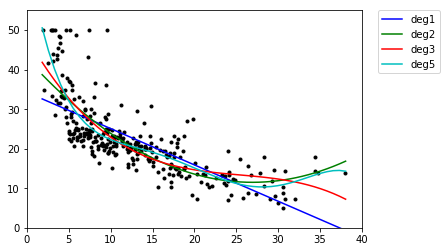

In [7]:
min_loss = np.Inf
plt.plot(X_train, y_train, 'k.')

# Try different polynomial degrees
for deg in [1,2,3,5]:
    # Expand data first; you can check how this function works in utils.py
    X, C = degexpand(X_train, deg)
    y = y_train
    
    # Get the result by applying normal equation
    w = lsqClosedForm(X, y)
    
    # compute loss on training
    loss = symmLoss(X, w, y)
    
    # compute loss on val; note -- use the same scaling matrix C as for training
    val_loss = symmLoss(degexpand(X_val, deg, C)[0], w, y_val)
    print('degree %d:' %(deg))
    print('train loss %.6f' %(loss))
    print('val loss %.6f' %(val_loss))
    print('sigma^2: %.6f \nlog-likelihood %.6f\n' %logLikelihood(X, w, y))
    
    if val_loss < min_loss:
        min_loss = val_loss
        # record in best_param (0) the model weights, (1) degree, and (2) the scaling matrix of the best model so far
        best_param = (w, deg, C)
    
    # Plot the function
    color = {1:'b', 2:'g', 3:'r', 5:'c'}[deg]
    plt.plot(np.linspace(min(X_train)-.1,max(X_train)+.1), np.dot(degexpand(np.linspace(min(X_train)-.1,max(X_train)+.1).reshape((50, 1)), deg, C)[0], w), color,label='deg'+str(deg))

axes = plt.gca()
axes.set_xlim([0,40])
axes.set_ylim([0,55])
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)

In [8]:
# Announce result on validation data

dataTest=np.loadtxt('housing-val.txt')
print("Best degree:"+repr(best_param[1])+", loss (sym) on val:")
print(symmLoss(degexpand(X_val, best_param[1], best_param[2])[0], best_param[0], y_val))

Best degree:3, loss (sym) on val:
31.2463301689


We select the best model based on the validation loss. If we were to select based on train loss, we would (of course) select the most complex model since it has the highest capacity to fit the training data. here the differences between 2nd and 3rd degree models are tiny, but measurable.

Now we want to repeat the experiment above but under the asymmetric loss function. Since there is no closed form solution, we will need to rely on gradient descent. First we need to implement the loss function and the gradient function.

In [9]:
def asymmLoss(X, w, y,alpha,_grad=False):
    """
    Get the asymmetric loss given data X, weight w and ground truth y

    Parameters
    ----------
    X : 2D array
        N x d+1 design matrix (row per example)
    w : 1D array
        d+1 length vector
    y : 1D array
        Observed function values

    Returns
    -------
    loss : a scalar
        The loss calculated by equation in problem set 1
    """
    N = X.shape[0]
    yhat = np.dot(X, w)
    weights=np.zeros([N,N])
    for i in range(0,N):
        if yhat[i] < y[i]:
            weights[i][i] = alpha
        else:
            weights[i][i] = 1
    loss = (np.dot(yhat-y,np.dot(weights,yhat-y))) / N
    if _grad:
        grad = 2*np.dot(X.transpose(),np.dot(weights,yhat-y)) / N
        return loss, grad
    else:
        return loss
    

Test the loss and gradient function.

In [10]:
loss, grad = asymmLoss(np.array([[1,2], [1, -3]]), np.array([1,1]), np.array([4, -4]),10,_grad=True)
print("expected output")
print("7.0")
print("[ -8 -26]")
print("function output:")
print(loss)
print(grad)


expected output
7.0
[ -8 -26]
function output:
7.0
[ -8. -26.]


Since we have had the functions to calculate loss and gradient, we can implement the gradient descent algorithm.

In [11]:
def gradDescent(X, y,alpha,tol=1e-4,maxIt=10000,checkit=1000,verbose=2,lr=0.01):
    """
    Use gradient descent to min(loss(X, w, y))

    Parameters
    ----------
    X : 2D array
        N x d+1 design matrix (row per example)
    y : 1D array
        Observed function values
    alpha : scalar
        weight on positive errors in asymmetric loss
    tol : scalar
        tolerance on loss decrease (default 1e-4)
    maxIt : scalar
        max allowed number of iterations

    Returns
    -------
    w : 1D array
        d+1 length vector
        
    it: number of iterations until convergence
    """
    # Random initialize the weight
    w = np.random.randn(X.shape[1])
    it = 0
    lastloss = np.Inf
    while True:
        it += 1 # advance iteration count
        loss, grad = asymmLoss(X, w, y,alpha,_grad=True) # eval. loss and compute gradient
        
        if it % checkit == 0:
            converged = it >= maxIt or loss > lastloss-tol
            lastloss = loss
            if verbose==2 or verbose==1 and it % (10*checkit) == 0:
                print('iter %d:  loss %.4f' %(it,loss))
            if converged:
                break
            
        w = w - lr * grad # update w (only if continuing updates)
       
        
    return w, it

Test gradient descent using any alpha and data generated by (random) noiseless linear model; we should recover the true w accurately (although possibly with less accuracy than the closed form solution for alpha=1)

In [12]:
X = np.hstack((np.ones([20,1]),np.random.random((20,1))))
w = np.random.random((2))
y = np.dot(X,w)
print('true weight:'+repr(w))
w_, it_ = gradDescent(X, y,10,maxIt=10000,tol=1e-6)
print('%d iterations' %it_)
print('function output:'+repr(w_))

true weight:array([ 0.33815234,  0.13241118])
iter 1000:  loss 0.0000
iter 2000:  loss 0.0000
iter 3000:  loss 0.0000
3000 iterations
function output:array([ 0.33814172,  0.13243911])


Now we can start testing the preformance of models using aymmetric loss.

degree 1:
train loss 3.884467
val loss 3.850933

iter 10000:  loss 3.3923
degree 2:
train loss 3.391045
val loss 3.400246

iter 10000:  loss 3.4319
iter 20000:  loss 3.4193
iter 30000:  loss 3.4085
iter 40000:  loss 3.3995
iter 50000:  loss 3.3918
degree 3:
train loss 3.391786
val loss 3.399450

iter 10000:  loss 3.4420
iter 20000:  loss 3.4127
iter 30000:  loss 3.4001
iter 40000:  loss 3.3927
iter 50000:  loss 3.3869
degree 5:
train loss 3.386856
val loss 3.411312



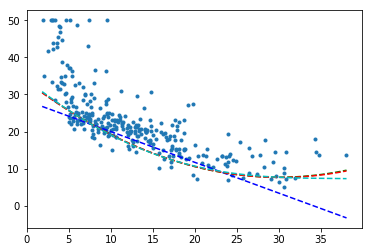

In [16]:
min_loss = np.Inf
# Try degree 1 to 3
plt.plot(X_train, y_train, '.')

alpha=.05;

for deg in[1,2,3,5]:
    # Expand data first
    X, C = degexpand(X_train, deg)
    y = y_train
        
    # Run gradient descent
    w, _ = gradDescent(X, y,alpha,maxIt=50000,checkit=1000,verbose=1,lr=1)
    loss = asymmLoss(X, w, y,alpha)
    val_loss = asymmLoss(degexpand(X_val, deg, C)[0], w, y_val,alpha)
    
    print('degree %d:' %(deg))
    print('train loss %.6f' %(loss))
    print('val loss %.6f\n' %(val_loss))
    

    
    if val_loss < min_loss:
        min_loss = val_loss
        best_param_asym = (w, deg, C)
        
    # Plot the function
    color = {1:'b', 2:'g', 3:'r', 5:'c'}[deg]
    plt.plot(np.linspace(min(X_train)-.1,max(X_train)+.1), np.dot(degexpand(np.linspace(min(X_train)-.1,max(X_train)+.1).reshape((50, 1)), deg, C)[0], w), color + '--')
    


In [14]:
# Announce result on validation data

dataTest=np.loadtxt('housing-val.txt')
print("Best degree:"+repr(best_param[1])+", loss (asym) on val:")
print(asymmLoss(degexpand(X_val, best_param_asym[1], best_param_asym[2])[0], best_param_asym[0], y_val,alpha))

Best degree:3, loss (asym) on val:
3.39970022591


In [15]:
# Now measure results on test with asymmetric loss, for both models (one learned with sym loss and one learned with asym loss)

dataTest=np.loadtxt('housing-test.txt')
X_test=(dataTest[:,np.newaxis,0])
y_test=dataTest[:,1]

print("Best degree (sym):"+repr(best_param[1]))
print('Asym loss: %.4f' %asymmLoss(degexpand(X_test, best_param[1], best_param[2])[0], best_param[0], y_test,alpha))
print('Sym loss: %.4f' %symmLoss(degexpand(X_test, best_param[1], best_param[2])[0], best_param[0], y_test))
print('Log-likelihood (symmetric): %.4f\n' %logLikelihood(degexpand(X_test, best_param[1], best_param[2])[0], best_param[0], y_test)[1])


print("Best degree (asym):"+repr(best_param_asym[1]))
print('Asym loss: %.4f' %asymmLoss(degexpand(X_test, best_param_asym[1], best_param_asym[2])[0], best_param_asym[0], y_test,alpha))
print('Sym loss: %.4f' %symmLoss(degexpand(X_test, best_param_asym[1], best_param_asym[2])[0], best_param_asym[0], y_test))
print('Log-likelihood (symmetric): %.4f\n' %logLikelihood(degexpand(X_test, best_param_asym[1], best_param_asym[2])[0], best_param_asym[0], y_test)[1])



Best degree (sym):3
Asym loss: 10.9697
Sym loss: 22.1586
Log-likelihood (symmetric): -2.9681

Best degree (asym):3
Asym loss: 3.7285
Sym loss: 48.7367
Log-likelihood (symmetric): -3.3622



There are a few ways we could "compare the models" obtained under the two loss functions. 

1) compare the loss values (on val) using, for each model, the loss with which it was trained. This does not make sense because the two loss functions are not, strictly speaking, measured in the same units. Choice of the loss is driven by considerations outside of the learning setup (e.g., actual cost of different types of erros) and we can not objectively compare them within the learning setup.

2) compare the models using symmetric loss. Here of course the first model (quadratic trained with symloss) wins. However, we know that this loss is not what we want.

3) compare the models using asymmetric loss. This is arguably the best comparison, and here we see that the model trained with asymmetric loss wins by a significant margin. That's not particularly surprising, and the main lesson here is that the model trained with the loss which is a better match for the real objective will generally attain better performance under that objective. 

4) compare the log-likelihood of each model on the data, under each of the models. We can not do it here since we have not derived the noise model corresponding to the asymmetric loss (i.e., under which the ML estimate is equivalent to the asymmetric loss iminimizer). But if we did, we might see that the symmetric model achieves higher likelihood. This indicates that the symmetric model is a better <b>explanation</b> of the data -- but of course this is besides the point if our application suggests that asymmetric loss is more appropriate. This emphasizes the distinction between choice of loss, dicated by task at hand, and model of the data that may explain it best.